In [1]:
import pandas as pd
import gc

In [2]:
df = pd.read_csv("../data/fromAPI/cleaned_hourly_all.csv")

In [3]:
date_format = "%Y-%m-%d %H:%M:%S"
df["arrival_plan"] = pd.to_datetime(df["arrival_plan"], format=date_format)
df["departure_plan"] = pd.to_datetime(df["departure_plan"], format=date_format)
df["arrival_change"] = pd.to_datetime(df["arrival_change"], format=date_format)
df["departure_change"] = pd.to_datetime(df["departure_change"], format=date_format)
df["arrival_plan_hour"] = df["arrival_plan"].dt.hour


In [4]:
df.dropna(subset=["arrival_plan"], inplace=True)

In [5]:
ml_arrival = df.drop([
    'ID', 'train', 'path', 'eva_nr', 'category', 
    #'name', 
    'state', 
    'city',
    'zip', 
    #'long', 'lat', 
    'arrival_plan', 'departure_plan',
    'arrival_change', 'departure_change', 'arrival_delay_m',
    'depature_delay_m', 
    'hour', 
    #'arrival_delay_check',
    'departure_delay_check'
    #'arrival_plan_hour'
    ], axis=1)

In [6]:
ml_arrival.loc[ml_arrival["arrival_delay_check"] == "delay", ["arrival_delay_check"]] = 1
ml_arrival.loc[ml_arrival["arrival_delay_check"] == "on_time", ["arrival_delay_check"]] = 0
ml_arrival["arrival_delay_check"] = ml_arrival["arrival_delay_check"].astype(int)

In [7]:
ml_arrival.head()

,name,long,lat,arrival_delay_check,arrival_plan_hour
0,Aachen Hbf,6.091499,50.7678,0,13.0
1,Aachen Hbf,6.091499,50.7678,0,13.0
7,Aachen Hbf,6.091499,50.7678,0,13.0
8,Aachen Hbf,6.091499,50.7678,0,13.0
10,Aachen Hbf,6.091499,50.7678,1,13.0


In [8]:
ml_arrival.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1241603 entries, 0 to 1370586
Data columns (total 5 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   name                 1241603 non-null  object 
 1   long                 1241603 non-null  float64
 2   lat                  1241603 non-null  float64
 3   arrival_delay_check  1241603 non-null  int64  
 4   arrival_plan_hour    1241603 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 56.8+ MB


In [9]:
ml_arrival.name.nunique()

1996

In [10]:
ml_arrival.arrival_delay_check.value_counts()

arrival_delay_check
0    1135941
1     105662
Name: count, dtype: int64

In [11]:
ml_arrival_bystations = pd.get_dummies(ml_arrival, columns=["name"])

In [12]:
ml_arrival_bystations.head()

,long,lat,arrival_delay_check,arrival_plan_hour,name_Aachen Hbf,name_Aachen Schanz,name_Aachen West,name_Aachen-Rothe Erde,name_Aalen Hbf,name_Achern,...,name_Zorneding,name_Zossen,name_Zweibrücken Hbf,name_Zwickau (Sachs) Hbf,name_Zwingenberg (Bergstr),name_Züssow,name_Öhringen Hbf,name_Ötigheim,name_Übach-Palenberg,name_Übersee
0,6.091499,50.7678,0,13.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,6.091499,50.7678,0,13.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,6.091499,50.7678,0,13.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,6.091499,50.7678,0,13.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,6.091499,50.7678,1,13.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [14]:
X = ml_arrival_bystations.drop('arrival_delay_check',axis=1)
y = ml_arrival_bystations['arrival_delay_check']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42, shuffle=True, stratify=y)

In [15]:
gc.collect()

0

In [16]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [17]:
y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.51
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.47      0.64    567971
           1       0.13      0.86      0.23     52831

    accuracy                           0.51    620802
   macro avg       0.55      0.67      0.43    620802
weighted avg       0.90      0.51      0.60    620802

Confusion Matrix:
[[269526 298445]
 [  7529  45302]]


In [18]:
import seaborn as sns
import numpy as np

Text(50.722222222222214, 0.5, 'True')

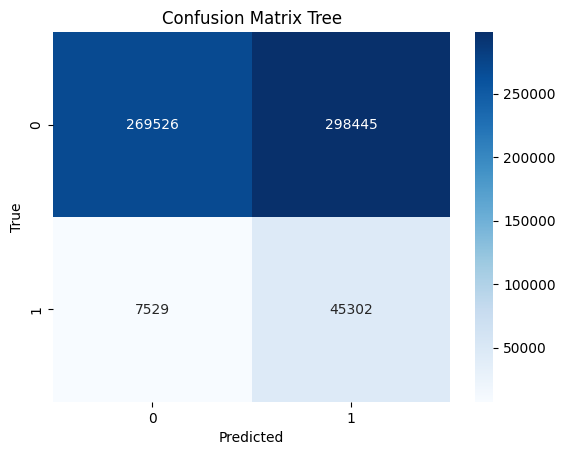

In [19]:
cmat = confusion_matrix(y_test, y_pred)
fig = sns.heatmap(cmat, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_pred), yticklabels=np.unique(y_pred))
fig.set_title('Confusion Matrix Tree')
fig.set_xlabel('Predicted')
fig.set_ylabel('True')

In [21]:
import pickle

with open('Models/nb.pkl', 'wb') as file:
    pickle.dump(nb, file)